## INITIALIZATION

In [1]:
%matplotlib notebook
import numpy as np
import time
import tables as tb
import matplotlib.pyplot as plt

from tjmonopix.tjmonopix import TJMonoPix
from tjmonopix.online_monitor import noise_monitor, plots
from tjmonopix.analysis import analysis_functions

import tjmonopix.scans.injection_scan

chip = TJMonoPix(conf="../tjmonopix/tjmonopix_mio3.yaml", no_power_reset=False)
chip.init(fl="EN_HV")

chip['data_rx'].CONF_START_FREEZE = 64 #default 3
chip['data_rx'].CONF_STOP_FREEZE = 100 #default 40
chip['data_rx'].CONF_START_READ = 66 #default 6
chip['data_rx'].CONF_STOP_READ = 68 #default 7
chip['data_rx'].CONF_STOP = 105 #default 45


2022-02-21 17:18:05,694 [INFO ] (MainThread) GPAC: power reset
2022-02-21 17:18:07,467 [INFO ] (MainThread) Found adapter card: General Purpose Analog Card (GPAC) with ID 3
2022-02-21 17:18:07,698 [INFO ] (MainThread) Found board 0 running firmware version 0.0
2022-02-21 17:18:07,953 [INFO ] (MainThread) ibias = 45
2022-02-21 17:18:07,967 [INFO ] (MainThread) ibias = 503.125 nA
2022-02-21 17:18:08,536 [INFO ] (MainThread) {'VPC [V]': 1.2998506463536463, 'VDDA_DAC [mA]': 2.502471747485684, 'VDDP [V]': 1.8049802771084336, 'VDDP OC': False, 'VDDA [mA]': 50.151368865825674, 'VDDD [V]': 1.8015140363636364, 'VDDA_DAC OC': False, 'VDDD [mA]': 2.820288999038665e-08, 'VPCSWSF [V]': 0.5001542395802099, 'VDDP [mA]': 128.39714805315754, 'BiasSF [V]': 1.061780067228218, 'VDDD OC': False, 'VPC [mA]': -0.021499899981273465, 'VPCSWSF [mA]': 0.11955933086167564, 'VDDA [V]': 1.8058565495495498, 'VDDA OC': False, 'VDDA_DAC [V]': 1.8035484515484517, 'BiasSF [mA]': 0.10059447096451782}


## POWER STATUS

In [2]:
#chip['BiasSF'].set_current(100, unit='uA') # SET THE SOURCE FOLLOWER READOUT CURRENT
chip.get_power_status()

{'BiasSF [V]': 1.062780289971045,
 'BiasSF [mA]': 0.10059447096451782,
 'VDDA OC': False,
 'VDDA [V]': 1.8058565495495498,
 'VDDA [mA]': 50.151368865825674,
 'VDDA_DAC OC': False,
 'VDDA_DAC [V]': 1.8035484515484517,
 'VDDA_DAC [mA]': 2.502471747485684,
 'VDDD OC': False,
 'VDDD [V]': 1.8005150383838384,
 'VDDD [mA]': 2.820288999038665e-08,
 'VDDP OC': False,
 'VDDP [V]': 1.8049802771084336,
 'VDDP [mA]': 128.39714805315754,
 'VPC [V]': 1.2998506463536463,
 'VPC [mA]': -0.04999977443009019,
 'VPCSWSF [V]': 0.5001542395802099,
 'VPCSWSF [mA]': 0.14907397590665358}

## ANALOG FRONT END CONFIGURATION

In [9]:
vl_dac = 40
vh_dac = 80
vreset_dac = 35
icasn_dac = 0  # This sets the baseline voltage of the discriminator input
ireset_dac = 2
ithr_dac = 5  # Also this sets the baseline voltage of the discriminator input
idb_dac = 50  # This sets the threshold of the discriminator. It is changed later.
ibias_dac = 100

## SET THE INJECTION PULSE AMPLITUDE
## 128-bit DAC (7-bit binary equivalent)
## SET THE VOLTAGES IN ONE HOT ENCODING, ONLY ONE BIT ACTIVE AT A TIME.
## V = (127/1.8)*#BIT
# The default values are VL=44, VH=79, VH-VL=35
# VDAC LSB=14.17mV, Cinj=230aF, 1.43e-/mV, ~710e-  
CAPCAL=20.3439450687
vl = chip.set_vl_dacunits(vl_dac,1)
vh = chip.set_vh_dacunits(vh_dac,1)

chip.write_conf()

# SET VRESET_P, THIS IS THE BASELINE OF THE FRONT END INPUT, ONE HOT ENCODING
vreset = chip.set_vreset_dacunits(vreset_dac, 1) #1V

## 128-bit DAC (7-bit binary equivalent)
## SET THE CURRENTS USING THERMOMETER ENCODING, I = #BITS_ACTIVE*140nA*SCALING, SCALING IS DIFFERENT FOR EACH CURRENT
## SCALING: IBIAS=10, IDB=16, ITHR=0.125, ICASN=4, IRESET=0.03125
## ACTIVE BITS SHOULD BE SET STARTING FROM THE MIDDLE e.g. for 15 active bits, (128-15)/2=56,5 so 56zeros,15ones,57zeros
## Thus, Ix[71:57] = True

# SET ICASN, THIS CURRENT CONTROLS THE OUTPUT BASELINE, BE CAREFUL NOT TO SET IT TO HIGH
# ALWAYS MONITOR THE POWER AFTER SETTING ICASN. IF VDDD IS SEVERAL mA, REDUCE IT UNTIL IT RETURNS TO 0
# ICASN MAINLY CONTROLS THE THRESHOLD
icasn = chip.set_icasn_dacunits(icasn_dac,1) #4.375nA # approx 1.084V at -3V backbias, 600mV at 0V backbias

# SET IRESET, THIS CURRENT CONTROLS THE RESET RATE OF THE FRONT END INPUT (ALSO THE THRESHOLD)
ireset = chip.set_ireset_dacunits(ireset_dac,1,1) #270pA, HIGH LEAKAGE MODE, NORMAL SCALING, 0 = LOW LEAKAGE MODE, SCALING*0.01

# SET ITHR, THIS CURRENT CONTROLS THE RESET RATE OF THE OUTPUT (AND THE THRESHOLD)
ithr = chip.set_ithr_dacunits(ithr_dac,1) #680pA ## default=5

# SET ITHR, THIS CURRENT CONTROLS THE BIASING OF THE DISCRIMINATOR (AND THE THRESHOLD)
idb = chip.set_idb_dacunits(idb_dac,1) #500nA  

# SET IBIAS, THIS CURRENT IS THE DC CURRENT OF THE MAIN BRANCH OF THE FRONT END THAT PROVIDES AMPLIFICATION
# IT CONTROLS MAINLY THE RISE TIME
ibias = chip.set_ibias_dacunits(ibias_dac,1) #500nA default=50

############ ENABLE THE DAC CURRENT MONITORING ###########
# chip['CONF_SR']['SWCNTL_DACMONI'] = 0

########## SET THE BIAS CURRENTS OF THE TWO STAGE SOURCE FOLLOWER THAT BUFFERS THE ANALOG MONITORING VOLTAGES #########
# CONTROLS THE RESPONSE TIME AND THE LEVEL SHIFT OF THE BUFFER
# chip['CONF_SR']['SET_IBUFN_L'] = 0b1001
# chip['CONF_SR']['SET_IBUFP_L'] = 0b0101

chip.write_conf()


setted_param_dac = np.array([vl_dac, vh_dac, vreset_dac, icasn_dac, ireset_dac, ithr_dac, idb_dac, ibias_dac])
setted_param = np.array([vl, vh, vreset, icasn, ireset, ithr, idb, ibias])

2022-02-21 17:22:31,901 [INFO ] (MainThread) vl = 0.951929133858V
2022-02-21 17:22:31,923 [INFO ] (MainThread) vh = 1.51885826772V
2022-02-21 17:22:31,938 [INFO ] (MainThread) vreset = 1.05106299213V
2022-02-21 17:22:31,954 [INFO ] (MainThread) icasn = 0
2022-02-21 17:22:31,970 [INFO ] (MainThread) icasn = 4.375 nA
2022-02-21 17:22:31,986 [INFO ] (MainThread) ireset = 2 high leakage mode
2022-02-21 17:22:32,000 [INFO ] (MainThread) ireset = 0.1025390625nA, high leakage mode
2022-02-21 17:22:32,007 [INFO ] (MainThread) ithr = 5
2022-02-21 17:22:32,023 [INFO ] (MainThread) ithr = 0.8203125 nA
2022-02-21 17:22:32,039 [INFO ] (MainThread) idb = 50
2022-02-21 17:22:32,055 [INFO ] (MainThread) idb = 892.5 nA
2022-02-21 17:22:32,069 [INFO ] (MainThread) ibias = 100
2022-02-21 17:22:32,085 [INFO ] (MainThread) ibias = 1104.6875 nA


## ENABLE MASK AND GET OCCUPANCY

In [10]:
th = 2
step = 50
dt = 0.2

noisy_pixels, n_disabled_pixels, mask = chip.auto_mask(th=th, step=step, dt=dt)
print("========= Getting residual occupancy =============")
pix_tmp, cnt = chip.get_occupancy(dt);

Enable MASKH 50
Got 48180 hits, total noisy pixels: 30
Enable MASKH 100
Got 103295 hits, total noisy pixels: 85
Enable MASKH 150
Got 24090 hits, total noisy pixels: 128
Enable MASKH 200
Got 159748 hits, total noisy pixels: 198
Enable MASKH 223
Got 37839 hits, total noisy pixels: 222
Enable MASKV 50
Got 115 hits, total noisy pixels: 224
Enable MASKV 100
Got 8 hits, total noisy pixels: 225
Enable MASKV 111
Got 37 hits, total noisy pixels: 229
Enable MASKD 50
Got 108 hits, total noisy pixels: 235
Enable MASKD 100
Got 8 hits, total noisy pixels: 237
Enable MASKD 150
Got 8 hits, total noisy pixels: 238
Enable MASKD 200
Got 60 hits, total noisy pixels: 242
Enable MASKD 250
Got 93 hits, total noisy pixels: 242
Enable MASKD 300
Got 38 hits, total noisy pixels: 246
Enable MASKD 350
Got 12 hits, total noisy pixels: 247
Enable MASKD 400
Got 16 hits, total noisy pixels: 247
Enable MASKD 447
Got 127 hits, total noisy pixels: 247
Checking again after masking
Got 124 hits, total noisy pixels: 249
Noi

# Configure injection and Select 1pixel 

2022-02-21 17:22:46,357 [INFO ] (MainThread) idb = 50
2022-02-21 17:22:46,372 [INFO ] (MainThread) idb = 892.5 nA
2022-02-21 17:22:46,388 [INFO ] (MainThread) vh = 1.80232283465V


('pixel (col and row) injected', 66, 10)
Got 218 hits in 0.2 s


<IPython.core.display.Javascript object>


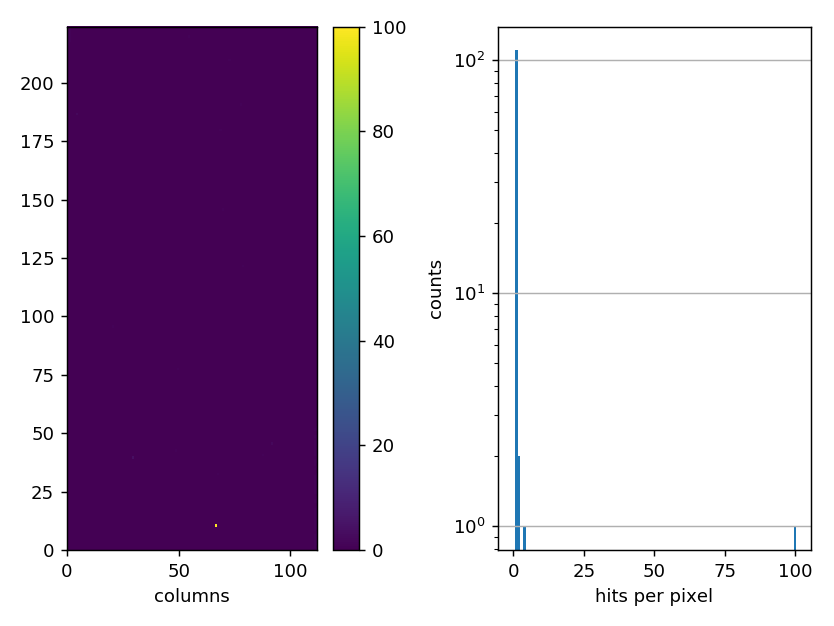

2022-02-21 17:22:48,779 [WARNI] (MainThread) Deprecated: Use get_FIFO_SIZE()


fifo size 1548
0 (66, 10) 100
1 (20, 95) 3
2 (29, 39) 2
3 (69, 145) 2
4 (9, 149) 2
5 (102, 8) 1
6 (2, 42) 1
7 (2, 125) 1
8 (6, 182) 1
9 (7, 164) 1
10 (17, 216) 1
11 (26, 215) 1
12 (27, 214) 1
13 (45, 24) 1
14 (44, 210) 1
15 (98, 141) 1
16 (47, 150) 1
17 (50, 60) 1
18 (53, 58) 1
19 (54, 219) 1
20 (61, 184) 1
21 (77, 190) 1
22 (78, 121) 1
23 (80, 38) 1
24 (1, 145) 1
Wall time: 2.44 s


In [11]:
%%time
import tjmonopix.scans.injection_scan
reload(tjmonopix.scans.injection_scan)

delay = 800 #in clock units (640 MHz)
width = 250
repeat = 100 #number of pulse injected
chip['inj'].set_delay(delay)
chip['inj'].set_width(width)
chip['inj'].set_repeat(repeat)
chip['inj'].set_phase(0)
chip['inj'].set_en(0)

idb = chip.set_idb_dacunits(50,1) #### threshold; SOPRA LA METTE CON 50 DAC
vh = chip.set_vh_dacunits(100,1) #### injection; SOPRA LA METTE CON 80 DAC
chip.write_conf()

col_to_inject = 66
row_to_inject = 10
chip.select_injection(col_to_inject, row_to_inject)

_, pixels, hits_per_pixel = plots.tj_plot(chip, wait_inj=True)
chip['data_rx'].set_en(False)

chip.set_monoread()
for _ in range(5):
    chip['fifo'].reset()
    time.sleep(0.002)
chip["inj"].start()
while not chip['inj'].is_ready:
    time.sleep(0.001)
time.sleep(0.2)

print "fifo size", chip['fifo'].get_fifo_size()
ix = chip.interpret_data(chip['fifo'].get_data())
uni, cnt = np.unique(ix[["col","row"]], return_counts = True)
arg = np.argsort(cnt)
for a_i, a in enumerate(arg[::-1]):
    print a_i, uni[a], cnt[a]
    

## run parameter space scan using injection_scan

In [12]:
%%time
delay = 800 #in clock units (640 MHz)
width = 250
repeat = 100 #number of pulse injected
chip['inj'].set_delay(delay)
chip['inj'].set_width(width)
chip['inj'].set_repeat(repeat)
chip['inj'].set_phase(0)
chip['inj'].set_en(0)

idb = chip.set_idb_dacunits(20,1) 
vh = chip.set_vh_dacunits(80,1) # The functions below change vl w.r.t. vh
chip.write_conf()

scans = tjmonopix.scans.injection_scan.InjectionScan(dut=chip)

collist = list(range(95,112))
rowlist = list(range(224))
injlist = np.arange(40, 0, -1)
thlist = [20] #list(range(20, 30))

output_filename = scans.start(
    collist = collist, rowlist = rowlist,
    injlist = injlist, thlist = thlist, phaselist = None,
    with_mon = False, n_mask_col = 5, debug = 4)


2022-02-21 17:24:17,071 [INFO ] (MainThread) idb = 20
2022-02-21 17:24:17,086 [INFO ] (MainThread) idb = 367.5 nA
2022-02-21 17:24:17,101 [INFO ] (MainThread) vh = 1.51885826772V
2022-02-21 17:24:17,124 [INFO ] (MainThread) Initializing InjectionScan
2022-02-21 17:24:19,908 [INFO ] (MainThread) Power status: {'VPC [V]': 1.2998506463536463, 'VDDA_DAC [mA]': 2.502471747485684, 'VDDP [V]': 1.8049802771084336, 'VDDP OC': False, 'VDDA [mA]': 79.53297889485958, 'VDDD [V]': 1.8005150383838384, 'VDDA_DAC OC': False, 'VDDD [mA]': 2.820288999038665e-08, 'VPCSWSF [V]': 0.5001542395802099, 'VDDP [mA]': 143.50269488026495, 'BiasSF [V]': 1.0647807354566992, 'VDDD OC': False, 'VPC [mA]': 0.44899802732287647, 'VPCSWSF [mA]': -0.03701836234303773, 'VDDA [V]': 1.8048574894894895, 'VDDA OC': False, 'VDDA_DAC [V]': 1.8035484515484517, 'BiasSF [mA]': 0.10059447096451782}
2022-02-21 17:24:20,009 [INFO ] (MainThread) Temperature (C): 30.388751
2022-02-21 17:24:20,065 [INFO ] (MainThread) Temperature (C): 30.

sleeping


2022-02-21 17:24:25,657 [WARNI] (MainThread) SRAM FIFO not empty after reset: size = 2650988
2022-02-21 17:25:06,332 [INFO ] (MainThread) Set timestamp: src=inj
2022-02-21 17:25:06,980 [INFO ] (MainThread) Starting FIFO readout
2022-02-21 17:25:07,017 [WARNI] (MainThread) SRAM FIFO not empty when starting FIFO readout: size = 645876


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 69)
('row', 69)
('row', 69)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('ro

('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('ro

('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 106)
('row', 106)

('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)

('row', 135)
('row', 135)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)

('row', 151)
('row', 151)
('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)

('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)

('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)

('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)

('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)

2022-02-21 17:27:37,927 [INFO ] (MainThread) scan_param_id=0 dat=10637632: cols=[ 95  99 103 107 111]


('row', 223)
('row', 223)
('row', 223)
('row', 223)


2022-02-21 17:27:38,467 [INFO ] (MainThread) Stopped FIFO readout
2022-02-21 17:27:38,482 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('row', 20)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('ro

('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('ro

('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)

('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)

('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)

('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)

('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)

('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)

('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)

('row', 214)
('row', 214)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)

2022-02-21 17:30:09,266 [INFO ] (MainThread) scan_param_id=1 dat=-1731547: cols=[ 96 100 104 108]


('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)


2022-02-21 17:30:09,799 [INFO ] (MainThread) Stopped FIFO readout
2022-02-21 17:30:09,815 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('ro

('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('ro

('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)

('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)

('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)

('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)

('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)

('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 185)
('row', 185)

('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)

('row', 214)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)

2022-02-21 17:32:40,871 [INFO ] (MainThread) scan_param_id=2 dat=-42387: cols=[ 97 101 105 109]


('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)


2022-02-21 17:32:41,410 [INFO ] (MainThread) Stopped FIFO readout
2022-02-21 17:32:41,424 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 17)
('row', 17)
('row', 17)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('ro

('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('ro

('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)

('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)

('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)

('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)

('row', 166)
('row', 166)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)

('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)

('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)

('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)

2022-02-21 17:35:12,634 [INFO ] (MainThread) scan_param_id=3 dat=21885: cols=[ 98 102 106 110]


('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)


2022-02-21 17:35:13,167 [INFO ] (MainThread) Stopped FIFO readout
2022-02-21 17:35:13,183 [INFO ] (MainThread) g=None, dat=0
2022-02-21 17:35:13,197 [INFO ] (MainThread) Recived words: 8885583
2022-02-21 17:35:13,220 [INFO ] (MainThread) Data queue size: 0
2022-02-21 17:35:13,236 [INFO ] (MainThread) SRAM FIFO size: 0
2022-02-21 17:35:13,252 [INFO ] (MainThread) Channel:                     TDC | DATA_RX | TLU | TIMESTAMP
2022-02-21 17:35:13,266 [INFO ] (MainThread) Discard counter:             None |       0 |   0 |         0
2022-02-21 17:35:13,851 [INFO ] (MainThread) Power status: {'VPC [V]': 1.2998506463536463, 'VDDA_DAC [mA]': 2.502471747485684, 'VDDP [V]': 1.8049802771084336, 'VDDP OC': False, 'VDDA [mA]': 78.51981992834118, 'VDDD [V]': 1.8005150383838384, 'VDDA_DAC OC': False, 'VDDD [mA]': 2.820288999038665e-08, 'VPCSWSF [V]': 0.5001542395802099, 'VDDP [mA]': 129.40418450829804, 'BiasSF [V]': 1.063780512713872, 'VDDD OC': False, 'VPC [mA]': 0.060999736581090765, 'VPCSWSF [mA]':

Wall time: 10min 57s


In [13]:
%%time
scans.analyze(output_filename)

0 37292997 100.000% 0.448s 12431000hits 0errs
data (inj_n 100,inj_loop 8960): INJ=2849475 MONO=7150525 MON=0
0 9999997 80.444% 223.781s 7044624hits 0errs
data (inj_n 100,inj_loop 8960): INJ=734526 MONO=1696477 MON=0
9999997 2431003 100.000% 280.255s 1696477hits 0errs
Wall time: 4min 52s


'C:\\Users\\belle2\\tjmonopix-daq\\examples\\output_data\\20220221_172417_injection_ev.h5'

<IPython.core.display.Javascript object>


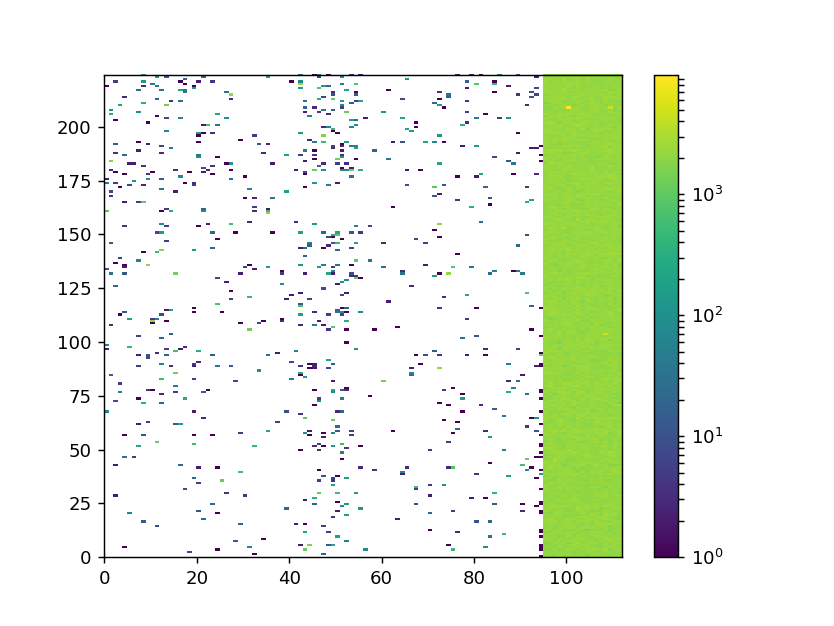

In [14]:
import tables
import matplotlib.colors
with tables.open_file(output_filename[:-len("scan.h5")]+"hit.h5") as f:
    plt.figure()
    plt.hist2d(f.root.Hits[:]["col"], f.root.Hits[:]["row"],
               bins=[112,224], range=[[0,112],[0,224]],
               norm=matplotlib.colors.LogNorm())
    plt.colorbar()
    plt.show()